In [1]:
import obspy
import seisbench
import seisbench.models as sbm
import pandas as pd
import pickle

from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape, GaussianNoise, Cropping2D 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, ZeroPadding2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

2022-04-13 18:32:22.260255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 18:32:22.260301: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
time = np.arange(0, 86.4, 0.00001);
sine = np.sin(time)
noise = np.random.normal(0,0.1,8640000)
noisy_sine = sine + noise

zeros = [0] * 8640000
# sine_noise_by_time = [[noisy_sine[i], zeros[i], zeros[i]] for i in range(len(noisy_sine))]

stream = [noisy_sine, zeros, zeros]

# step_size = 1000 # originally 16, try to increase to 1000 to represent 10 seconds
# batched_stream_arr_by_time = [sine_noise_by_time[i:i + step_size] for i in range(0, len(sine_noise_by_time), step_size)]

In [3]:
from scipy import signal
freq, time, stft = signal.stft(noisy_sine, padded=False, nperseg = 2000 - 1)

stft_stream_by_time = np.asarray([np.asarray([np.asarray([stft[i][j], 0, 0]) for j in range(len(stft[i]))]) for i in range(len(stft))])
stft_stream_by_time

array([[[  7.07145509e-03 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        [  8.61576977e-03 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        [  1.74141232e-02 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        ..., 
        [ -9.95309544e-01 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        [ -1.00235248e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        [ -1.00220295e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j]],

       [[ -3.91612253e-03 +3.97730720e-03j,
           0.00000000e+00 +0.00000000e+00j,
           0.00000000e+00 +0.00000000e+00j],
        [ -2.64906266e-03 -1.63105884e-03j,
         

In [4]:
len(noisy_sine)

8640000

In [5]:
len(stft)

1000

In [6]:
len(stft[0])

8640

In [7]:
input_shape = (len(stft[0]), 3, 1)
# batch_size = 150
# no_epochs = 5
# train_test_split = 0.3
# validation_split = 0.2
# verbosity = 1
# max_norm_value = 2.0

## Testing Denoising Function

In [8]:
# data_noisy = stft_stream_by_time
# data_pure = [[sine[i], zeros[i], zeros[i]] for i in range(len(noisy_sine))]

freq, time, noisy_stft = signal.stft(noisy_sine, padded=False, nperseg = 2000 - 1)
freq, time, sine_stft = signal.stft(sine, padded=False, nperseg = 2000 - 1)

noisy_stft_by_time = np.asarray([np.asarray([np.asarray([noisy_stft[i][j], 0, 0]) for j in range(len(noisy_stft[i]))]) for i in range(len(noisy_stft))])
sine_stft_by_time = np.asarray([np.asarray([np.asarray([sine_stft[i][j], 0, 0]) for j in range(len(sine_stft[i]))]) for i in range(len(sine_stft))])

In [ ]:
inp = Input(shape=(len(stft[0]), 3, 1))  

e = GaussianNoise(0.2)(inp)
# e = Cropping2D(cropping=((0, 0), (1, 0)), data_format = None)(e)

e = Conv2D(8, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 3), padding='same')(e)
e = Conv2D(4, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)
e = Conv2D(2, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(2, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(4, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(8, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 3))(d)
# d = ZeroPadding2D((0, 1))(d)
# d = Cropping2D(cropping=((0, 0), (2499, 0)), data_format = None)(d)

decoded = Conv2D(1, (3, 3), padding='same')(d)


autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# autoencoder.compile(loss="mse", optimizer='adam')
model.compile(optimizer='adam', loss='binary_crossentropy')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.summary()

2022-04-13 18:34:19.136244: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-13 18:34:19.136322: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (n0014.savio1): /proc/driver/nvidia/version does not exist


In [ ]:
autoencoder.fit(noisy_stft_by_time, sine_stft_by_time, batch_size = 128, epochs=5, callbacks=[csv_logger])
# autoencoder.fit(stft_stream_by_time, stft_stream_by_time, batch_size=128, epochs=30, callbacks=[csv_logger])

## Clustering Below

In [9]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')


# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

ERROR! Session/line number was not unique in database. History logging moved to new session 250
...Finetuning...
ERROR! Session/line number was not unique in database. History logging moved to new session 251


In [10]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(stft_stream_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [11]:
def plot_waves(stream, predictions, step_size):
    fig = plt.figure(figsize=(16, 10))
    clusters = list(set(predictions))
    axs = fig.subplots(len(clusters)+1, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
                
    df = pd.DataFrame({'E': stream[0], 'N': stream[1], 'Z': stream[2]})
    df['y_pred'] = np.repeat(y_pred, step_size)
    
    for i in range(3):
        axs[0].plot(df.index, df.iloc[:, i], label = df.columns[i])
    
    for i in clusters:
        cluster = df[df['y_pred'] == i]
        for j in range(3):
            axs[i + 1].plot(cluster.index, cluster.iloc[:, j], label=df.columns[j])
        
        axs[i+1].legend()
        axs[i+1].title.set_text("Cluster " + str(i))
        
    axs[0].legend()
    axs[0].title.set_text("Stream")

    plt.show()
    return

In [12]:
# fourier transform then low pass filter

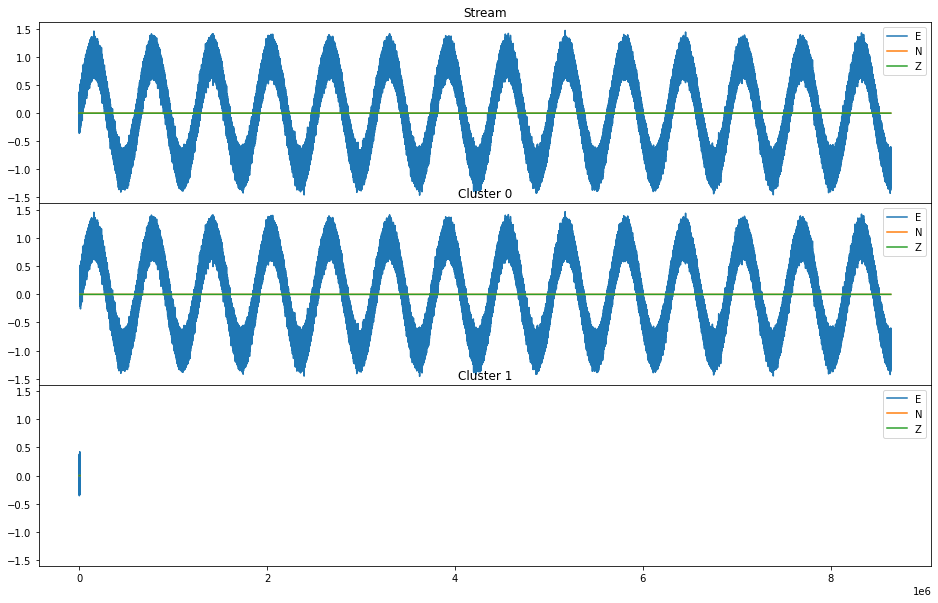

In [13]:
plot_waves(stream, y_pred, len(stft[0]))

## Application to Seismological Data

In [14]:
east_channel_path     = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPE.00.2020.342'
north_channel_path    = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPN.00.2020.342'
vertical_channel_path = '/global/scratch/users/taira/mleq/mseed/1001.HF.EPZ.00.2020.342'

stream = obspy.read(east_channel_path)
stream += obspy.read(north_channel_path)
stream += obspy.read(vertical_channel_path)

stream_arr = [list(stream[i].data) for i in range(3)]

In [20]:
from scipy import signal

freq_e, time_e, seis_stft_e = signal.stft(stream_arr[0], padded=False, nperseg = 2000 - 1)
freq_n, time_n, seis_stft_n = signal.stft(stream_arr[1], padded=False, nperseg = 2000 - 1)
freq_z, time_z, seis_stft_z = signal.stft(stream_arr[2], padded=False, nperseg = 2000 - 1)
print("here")
# seis_stft_by_time = []

seis_stft_by_time = np.asarray([np.asarray([np.asarray([seis_stft_e[i][j], seis_stft_n[i][j], seis_stft_z[i][j]]) for j in range(len(seis_stft_e[i]))]) for i in range(len(seis_stft_e))])
print("2")

# [[noisy_sine[i], zeros[i], zeros[i]] for i in range(len(noisy_sine))]
# batched_stream_arr_by_time = [sine_noise_by_time[i:i + step_size] for i in range(0, len(sine_noise_by_time), step_size)]

ERROR! Session/line number was not unique in database. History logging moved to new session 252
here
2


In [21]:
len(seis_stft_by_time[0])

8640

In [22]:
len(seis_stft_by_time[0][0])

3

In [23]:
inp = Input(shape=(len(seis_stft_by_time[0]), 3, 1))  

e = GaussianNoise(0.2)(inp)
# e = Cropping2D(cropping=((0, 0), (1, 0)), data_format = None)(e)

e = Conv2D(8, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 3), padding='same')(e)
e = Conv2D(4, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)
e = Conv2D(2, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(2, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(4, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(8, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 3))(d)
# d = ZeroPadding2D((0, 1))(d)
# d = Cropping2D(cropping=((0, 0), (2499, 0)), data_format = None)(d)

decoded = Conv2D(1, (3, 3), padding='same')(d)


autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# autoencoder.compile(loss="mse", optimizer='adam')
model.compile(optimizer='adam', loss='binary_crossentropy')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8640, 3, 1)]      0         
                                                                 
 gaussian_noise_2 (GaussianN  (None, 8640, 3, 1)       0         
 oise)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 8640, 3, 8)        80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4320, 1, 8)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 4320, 1, 4)        292       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2160, 1, 4)       

In [18]:
print('...Finetuning...')
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

...Finetuning...


In [24]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(seis_stft_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [25]:
stream

3 Trace(s) in Stream:
HF.1001.00.EPE | 2020-12-07T00:00:04.366000Z - 2020-12-08T00:00:04.362592Z | 100.0 Hz, 8640000 samples
HF.1001.00.EPN | 2020-12-07T00:00:04.366000Z - 2020-12-08T00:00:04.362592Z | 100.0 Hz, 8640000 samples
HF.1001.00.EPZ | 2020-12-07T00:00:04.366000Z - 2020-12-08T00:00:04.362592Z | 100.0 Hz, 8640000 samples

In [41]:
# need to fix later but plot waves has is differnet from one above, because 
# of what object the stream variable is

def plot_waves(stream, predictions, step_size):
    fig = plt.figure(figsize=(16, 10))
    clusters = list(set(predictions))
    axs = fig.subplots(len(clusters)+1, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
                
    df = pd.DataFrame({'E': stream[0].data, 'N': stream[1].data, 'Z': stream[2].data})
    df['y_pred'] = np.repeat(y_pred, step_size)
    
    for i in range(3):
        axs[0].plot(df.index, df.iloc[:, i], label = df.columns[i])
    
    for i in clusters:
        cluster = df[df['y_pred'] == i]
        for j in range(3):
            axs[i + 1].plot(cluster.index, cluster.iloc[:, j], label=df.columns[j])
        
        axs[i+1].legend()
        axs[i+1].title.set_text("Cluster " + str(i))
        
    axs[0].legend()
    axs[0].title.set_text("Stream")

    plt.show()
    return

## Plot for Two Clusters

here1
here2


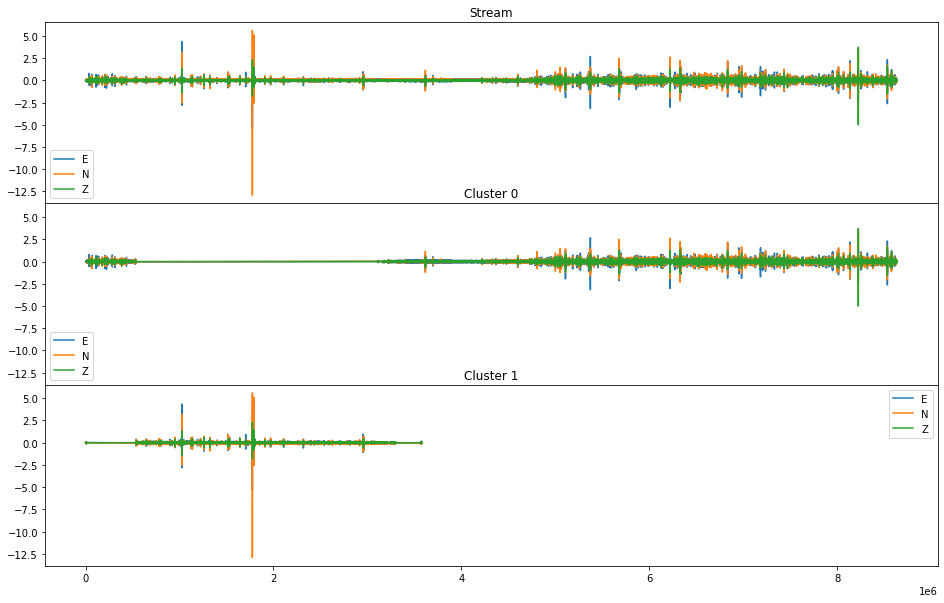

In [38]:
plot_waves(stream, y_pred, len(seis_stft_by_time[0]))

## Plot for 4 Clusters

In [42]:
print('...Finetuning...')
n_clusters = 4
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(seis_stft_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

...Finetuning...


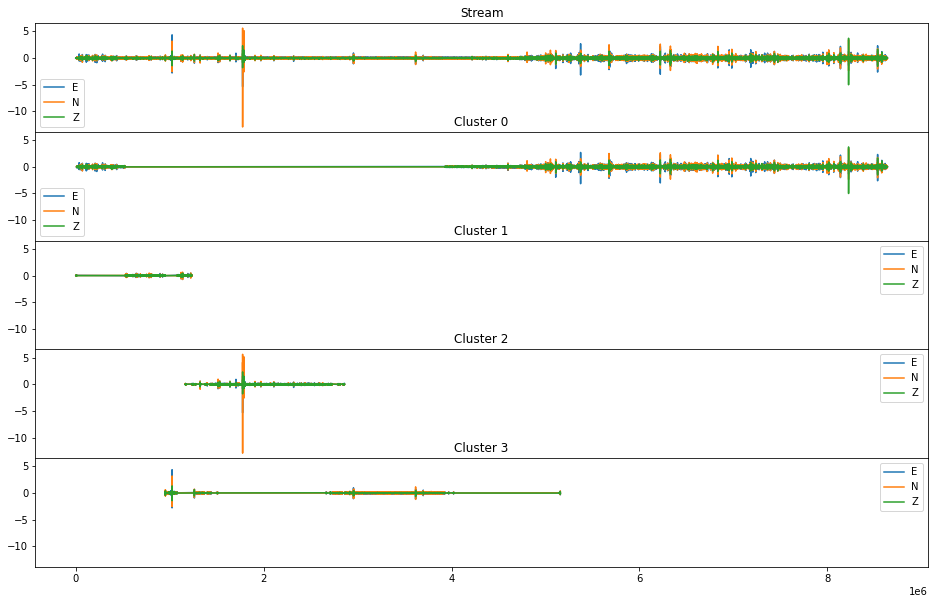

In [43]:
plot_waves(stream, y_pred, len(seis_stft_by_time[0]))

## Plot for 8 clusters

In [44]:
print('...Finetuning...')
n_clusters = 8
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(seis_stft_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

...Finetuning...


/global/home/groups/fc_ambient/seisbench/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


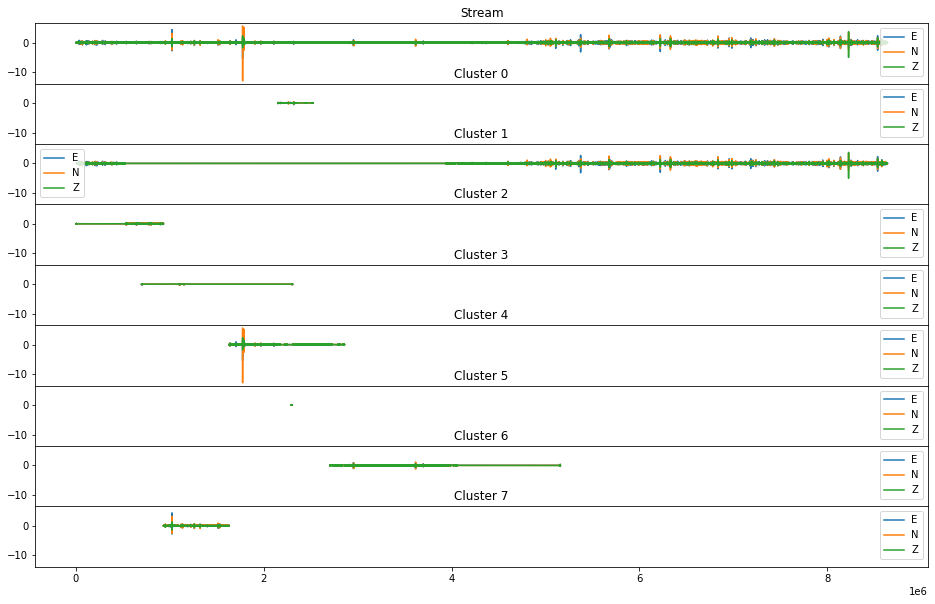

In [45]:
plot_waves(stream, y_pred, len(seis_stft_by_time[0]))

## Plot Longer Time Steps

In [47]:
from scipy import signal

freq_e, time_e, seis_stft_e = signal.stft(stream_arr[0], padded=False, nperseg = 20000 - 1)
freq_n, time_n, seis_stft_n = signal.stft(stream_arr[1], padded=False, nperseg = 20000 - 1)
freq_z, time_z, seis_stft_z = signal.stft(stream_arr[2], padded=False, nperseg = 20000 - 1)
# seis_stft_by_time = []

seis_stft_by_time = np.asarray([np.asarray([np.asarray([seis_stft_e[i][j], seis_stft_n[i][j], seis_stft_z[i][j]]) for j in range(len(seis_stft_e[i]))]) for i in range(len(seis_stft_e))])

# [[noisy_sine[i], zeros[i], zeros[i]] for i in range(len(noisy_sine))]
# batched_stream_arr_by_time = [sine_noise_by_time[i:i + step_size] for i in range(0, len(sine_noise_by_time), step_size)]

In [49]:
inp = Input(shape=(len(seis_stft_by_time[0]), 3, 1))  

e = GaussianNoise(0.2)(inp)
# e = Cropping2D(cropping=((0, 0), (1, 0)), data_format = None)(e)

e = Conv2D(8, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 3), padding='same')(e)
e = Conv2D(4, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)
e = Conv2D(2, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(2, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(4, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(8, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 3))(d)
# d = ZeroPadding2D((0, 1))(d)
# d = Cropping2D(cropping=((0, 0), (2499, 0)), data_format = None)(d)

decoded = Conv2D(1, (3, 3), padding='same')(d)


autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# autoencoder.compile(loss="mse", optimizer='adam')
model.compile(optimizer='adam', loss='binary_crossentropy')
csv_logger = CSVLogger('pretrain_log.csv')

# autoencoder.summary()

In [50]:
print('...Finetuning...')
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(seis_stft_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

...Finetuning...


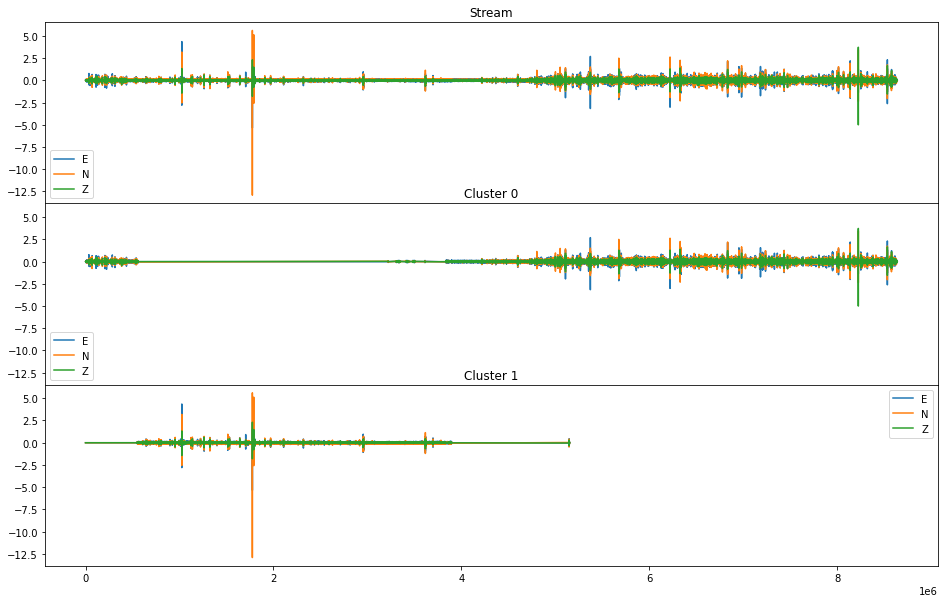

In [51]:
plot_waves(stream, y_pred, len(seis_stft_by_time[0]))

## Plot Shorter Timesteps

In [52]:
from scipy import signal

freq_e, time_e, seis_stft_e = signal.stft(stream_arr[0], padded=False, nperseg = 20000 - 1)
freq_n, time_n, seis_stft_n = signal.stft(stream_arr[1], padded=False, nperseg = 20000 - 1)
freq_z, time_z, seis_stft_z = signal.stft(stream_arr[2], padded=False, nperseg = 20000 - 1)
# seis_stft_by_time = []

seis_stft_by_time = np.asarray([np.asarray([np.asarray([seis_stft_e[i][j], seis_stft_n[i][j], seis_stft_z[i][j]]) for j in range(len(seis_stft_e[i]))]) for i in range(len(seis_stft_e))])

# [[noisy_sine[i], zeros[i], zeros[i]] for i in range(len(noisy_sine))]
# batched_stream_arr_by_time = [sine_noise_by_time[i:i + step_size] for i in range(0, len(sine_noise_by_time), step_size)]

In [53]:
inp = Input(shape=(len(seis_stft_by_time[0]), 3, 1))  

e = GaussianNoise(0.2)(inp)
# e = Cropping2D(cropping=((0, 0), (1, 0)), data_format = None)(e)

e = Conv2D(8, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 3), padding='same')(e)
e = Conv2D(4, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)
e = Conv2D(2, (3, 3), activation='selu', padding='same')(e)
e = MaxPooling2D((2, 1), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(2, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(4, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 1))(d)
d = Conv2D(8, (3, 3), activation='selu', padding='same')(d)
d = UpSampling2D((2, 3))(d)
# d = ZeroPadding2D((0, 1))(d)
# d = Cropping2D(cropping=((0, 0), (2499, 0)), data_format = None)(d)

decoded = Conv2D(1, (3, 3), padding='same')(d)


autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# autoencoder.compile(loss="mse", optimizer='adam')
model.compile(optimizer='adam', loss='binary_crossentropy')
csv_logger = CSVLogger('pretrain_log.csv')

# autoencoder.summary()

In [54]:
print('...Finetuning...')
n_clusters = 2
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=[encoder.input], outputs=[clustering_layer, autoencoder.output])
# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(seis_stft_by_time))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

...Finetuning...


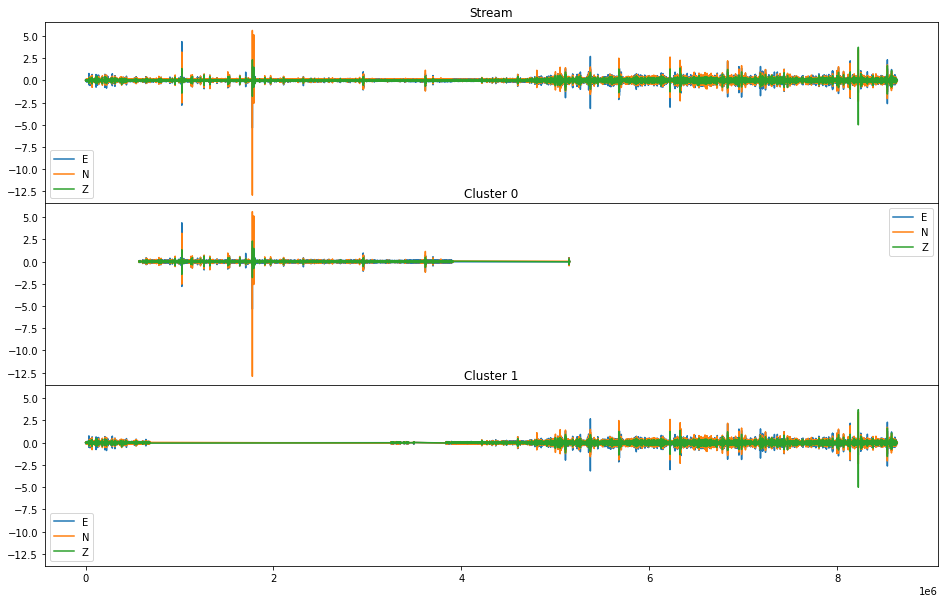

In [55]:
plot_waves(stream, y_pred, len(seis_stft_by_time[0]))